[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/031_regularization/regularization.ipynb)

# Regularización

Como hemos visto en el [post](https://sensioai.com/blog/030_data_splitting) anterior, cuando entrenamos `redes neuronales` corremos el riesgo de hacer *overfitting* a los datos de entrenamiento, lo cual se traducirá en una mala *performance* de nuestro modelo cuando le demos datos que no ha visto durante el entrenamiento, no sabrá generalizar. La mejor manera de saber si nuestro modelo sufre de este problema, es observar las curvas de entrenamiento. Vamos a entrenar un `MLP` en el dataset CIFAR10 para clasificación de imágenes en 10 clases diferentes.

In [1]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

> 💡 En este caso estamos utilizando la librería `torchvision` para descargar el dataset. En futuros posts hablaremos en detalle de esta librería, ya que nos da muchísima funcionalidad a la hora de trabajar en aplicaciones de visión artificial con `Pytorch`.

Este dataset está formado por imágenes en color de baja resolución, tenemos 50000 imágenes de entrenamiento y 10000 de test y el objetivo es el clasificar en 10 clases diferentes. Veamos algunos ejemplos.

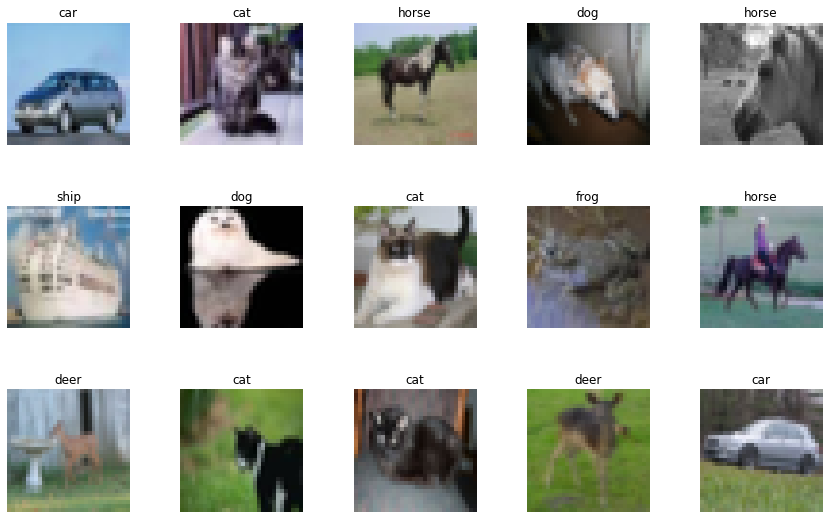

In [2]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Vamos a transformar las imágenes en `arrays` de `NumPy` para poder manejarlas de la misma manera que hemos hecho hasta ahora en los posts anteriores. También separaremos un conjunto de imágenes para validación así como un subset de imágenes para entrenar más rápido.

In [3]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

Ahora, podemos aplicar directamente el mismo código del post anterior para entrenar un `MLP` en esta tarea y ver las curvas de entrenamiento.

In [4]:
import torch

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [6]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [7]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.71091 acc 0.38057 val_loss 2.00228 val_acc 0.28860
Epoch 20/100 loss 1.49003 acc 0.46636 val_loss 1.95525 val_acc 0.33380
Epoch 30/100 loss 1.29666 acc 0.52389 val_loss 2.14103 val_acc 0.34130
Epoch 40/100 loss 1.14558 acc 0.58798 val_loss 2.26464 val_acc 0.32030
Epoch 50/100 loss 0.99655 acc 0.63694 val_loss 2.85555 val_acc 0.34590
Epoch 60/100 loss 0.82952 acc 0.70064 val_loss 2.66285 val_acc 0.38310
Epoch 70/100 loss 0.73307 acc 0.72990 val_loss 2.76875 val_acc 0.37060
Epoch 80/100 loss 0.65341 acc 0.76632 val_loss 3.75867 val_acc 0.34520
Epoch 90/100 loss 0.57130 acc 0.79817 val_loss 3.44383 val_acc 0.37350
Epoch 100/100 loss 0.47065 acc 0.83041 val_loss 4.04786 val_acc 0.37540


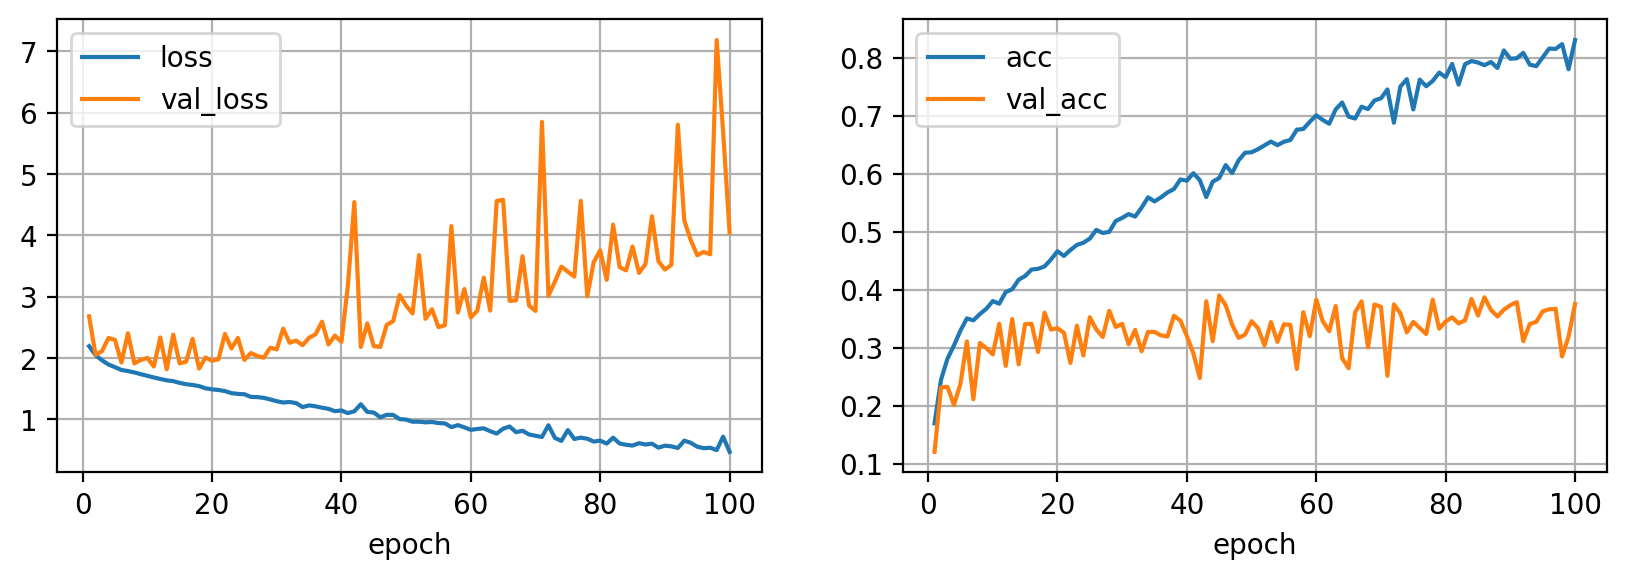

In [8]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar de las curvas de entrenamiento, las métricas para el conjunto de datos de entrenamiento van mejorando *epoch* tras *epoch*, sin embargo las métricas de validación rápidamente se estancan y empiezan a empeorar. Esta es la señal clara de que nuestro modelo está sufriendo de *overfitting*, y en las siguientes secciones veremos diferentes técnicas de **regularización**, el término técnico utilizado para referirnos a las diferentes técnicas de reducción de *overfitting*.

## Regularización L2

Una técnica re regularización muy utilizada es la regularización L2. Esta técnica consiste en restringir la magnitud de los pesos de la `red neuronal` forzándolos a ser valores pequeños. A efectos prácticos, la regularización L2 se implementa como un término extra en la función de pérdida

$$ l = CE(\hat{y}, y) + \alpha \frac{1}{2} || \mathbf{w} || $$

donde $CE(\hat{y}, y)$ es la  función *cross entropy* (o cualquier función de pérdida que uses dependiendo de tu caso), $\mathbf{w}$ son los pesos de la red y $\alpha$ es un parámetro indicando cuánto queremos regularizar el modelo. En `Pytorch` podemos asignar el valor de $\alpha$ mediante el parámetro `wieght_decay` directamente en el optimizador (por defecto está a 0). Valores típicos utilizados se encuentran en el rango 0.001 - 0.01.

In [9]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/100 loss 1.83388 acc 0.33499 val_loss 2.04523 val_acc 0.25300
Epoch 20/100 loss 1.82301 acc 0.35012 val_loss 1.90623 val_acc 0.30290
Epoch 30/100 loss 1.76697 acc 0.36346 val_loss 2.06482 val_acc 0.27650
Epoch 40/100 loss 1.76099 acc 0.36246 val_loss 2.50452 val_acc 0.18690
Epoch 50/100 loss 1.76963 acc 0.35868 val_loss 2.29614 val_acc 0.22900
Epoch 60/100 loss 1.74430 acc 0.37480 val_loss 1.89799 val_acc 0.30900
Epoch 70/100 loss 1.76294 acc 0.36346 val_loss 2.25807 val_acc 0.27890
Epoch 80/100 loss 1.74890 acc 0.37102 val_loss 1.87050 val_acc 0.32360
Epoch 90/100 loss 1.73594 acc 0.37341 val_loss 2.41314 val_acc 0.21050
Epoch 100/100 loss 1.73452 acc 0.37759 val_loss 1.96115 val_acc 0.30440


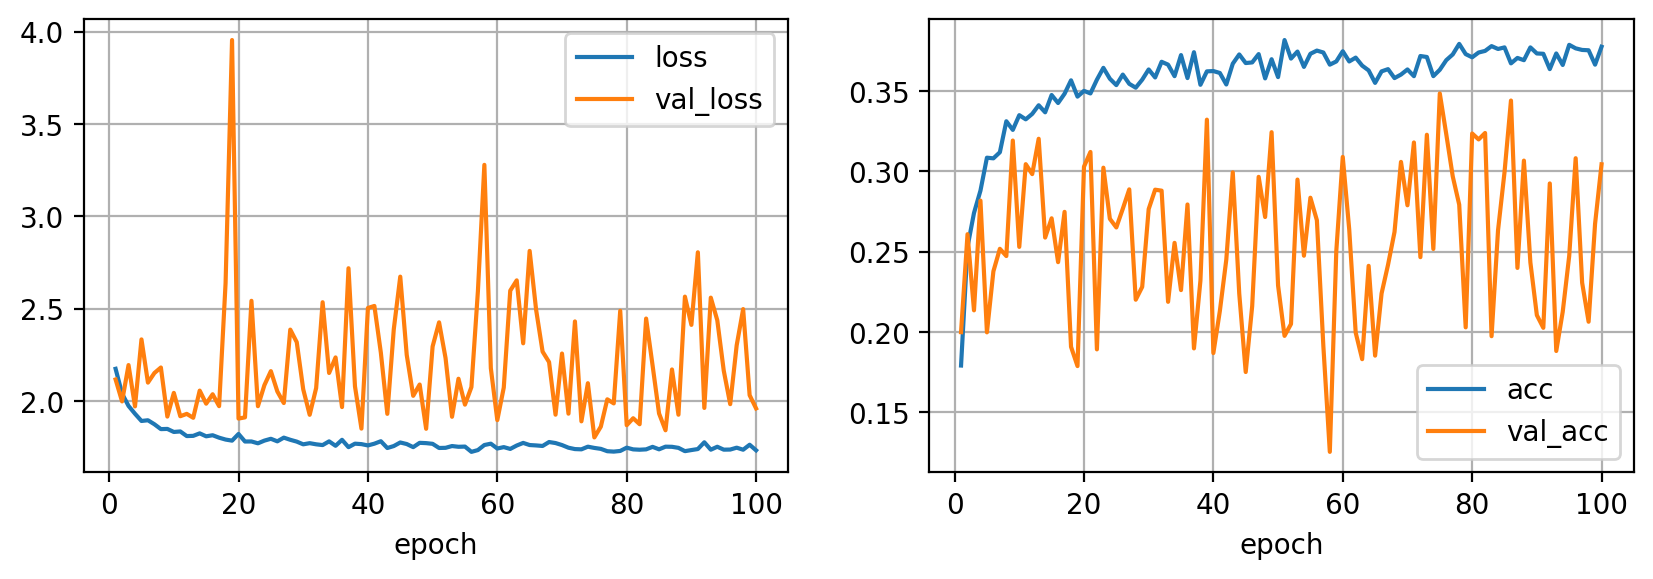

In [10]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como puedes observar ahora las curvas de entrenamiento y validación están más próximas, por lo que hemos disminuido el *overfitting*. Es importante remarcar que reducir el *overfitting* no implica mejorar las métricas.

## Early Stopping

Otra técnica muy utilizada para regularizar un modelo es el *early stopping*. Esta técnica consiste en llevar un registro de las métricas de validación durante el entrenamiento, guardar los pesos del modelo cada vez que mejoramos las mejores métricas obtenidas y, una vez terminado el entrenamiento, cargar los mejores pesos en vez de quedarnos con los últimos. De forma opcional también podemos detener el entrenamiento si no mejoramos nuestras métricas durante un número determinado de *epochs* seguidas, lo cual puede traducirse en un ahorro de tiempo y cómputo.

In [11]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [12]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.17620 en epoch 1
Mejor modelo guardado con acc 0.22370 en epoch 2
Mejor modelo guardado con acc 0.30280 en epoch 3
Epoch 10/100 loss 1.70231 acc 0.38296 val_loss 2.15461 val_acc 0.30130
Mejor modelo guardado con acc 0.31700 en epoch 11
Mejor modelo guardado con acc 0.33420 en epoch 14
Mejor modelo guardado con acc 0.34860 en epoch 19
Epoch 20/100 loss 1.48774 acc 0.45044 val_loss 2.13295 val_acc 0.30380
Entrenamiento detenido en epoch 29 por no mejorar en 10 epochs seguidas


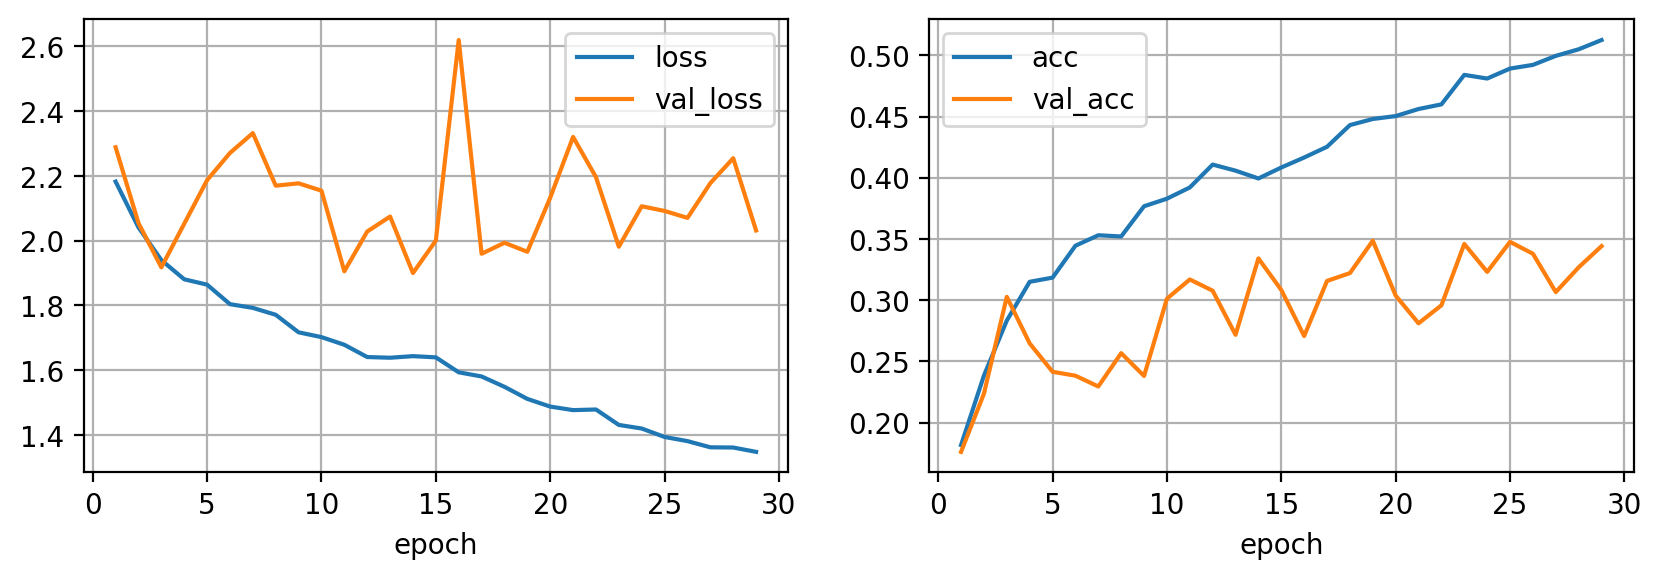

In [13]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Si comparas esta figura con la primera, podrás observar que si seguimos entrenando más *epochs* no vamos a encontrar un modelo mejor, por lo tanto no es necesario seguir entrenando ya que en este punto ya hemos encontrado el mejor modelo posible dadas las circunstancias. *Early stopping* es una técnica muy sencilla y efectiva, por lo que es recomendable utilizarla siempre.

> 💡 Aprende las diferente formas que `Pytorch` nos ofrece para guardar y cargar modelos [aquí](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

## Dropout

Otra técnica muy popular para reducir el *overfitting* es el uso de *Dropout*. Esta técnica se implementa como una capa extra en nuestra `red neuronal` cuyo objetivo es, durante el entrenamiento, "apagar" de manera aleatoria algunas neuronas de manera que forzaremos a nuestro modelo a aprender diferentes caminos dentro de la arquitectura para representar los mismos datos.

![](https://camo.githubusercontent.com/dd390e4b41997f2a8fd2eec1ffa5adfe4a2f8cfd/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f70726f78792f312a6957517a7868566c7661646b3656414a6a73675867672e706e67)

In [14]:
def build_model(D_in=32*32*3, H=100, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

Puedes añadir una capa de *Dropout* con la clase `torch.nn.Dropout`. El parámetro `p` controla la probabilidad de "apagar" una neurona. Este valor coincide con la proporción (en promedio) de neuronas que serán anuladas en una capa determinada.

> ⚡ Cuando no estamos entrenando, generalmente no queremos que la capa *Dropout* esté activa de manera que utilicemos todas las neuronas en el modelo. Podemos controlar el modo en el que trabaja la capa llamando a las funciones `model.train()` y `model.eval()`, las cuales se encargarán de asignar el modo adecuado a la capa *Dropout* (y cualquier otra capa de tu red que también tenga diferente comportamiento según estemos entrenando o evaluado el modelo). Esto es muy importante y fuente común de errores al trabajar con `Pytorch`. 

In [15]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.16900 en epoch 1
Mejor modelo guardado con acc 0.19260 en epoch 2
Mejor modelo guardado con acc 0.20170 en epoch 6
Mejor modelo guardado con acc 0.23300 en epoch 8
Epoch 10/100 loss 2.08967 acc 0.20601 val_loss 2.14575 val_acc 0.17490
Mejor modelo guardado con acc 0.23450 en epoch 14
Mejor modelo guardado con acc 0.24410 en epoch 16
Mejor modelo guardado con acc 0.26370 en epoch 17
Epoch 20/100 loss 2.04719 acc 0.22412 val_loss 2.08568 val_acc 0.21900
Mejor modelo guardado con acc 0.26870 en epoch 24
Epoch 30/100 loss 2.03060 acc 0.22651 val_loss 2.05998 val_acc 0.23510
Epoch 40/100 loss 2.02565 acc 0.22811 val_loss 2.00947 val_acc 0.23350
Mejor modelo guardado con acc 0.29090 en epoch 43
Epoch 50/100 loss 2.00900 acc 0.23467 val_loss 2.02116 val_acc 0.23070
Mejor modelo guardado con acc 0.29480 en epoch 54
Epoch 60/100 loss 1.97431 acc 0.25159 val_loss 1.94852 val_acc 0.27620
Epoch 70/100 loss 1.94281 acc 0.26811 val_loss 2.00555 val_acc 0.25220
Mejor m

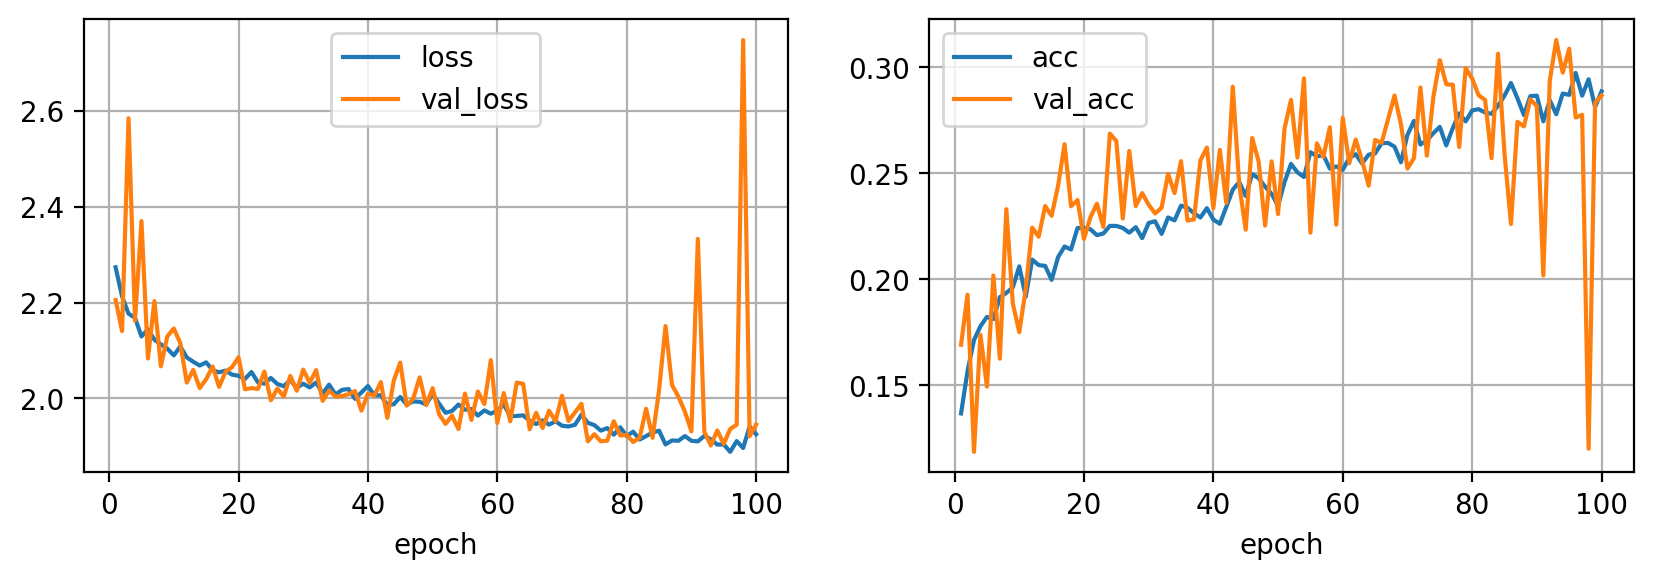

In [16]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

De nuevo observamos que las curvas de entrenamiento ya no presentan *overfitting*. Puedes jugar con la probabilidad de *Dropout* para controlar su efecto en el resultado final. De nuevo, date cuenta que reducir el *overfitting* no implica necesariamente que nuestro modelo tenga mejores prestaciones, simplemente estamos forzando al modelo a no "aprender de memoria" el dataset de entrenamiento.

## Usar más datos

La mejor manera de reducir el *overfitting* es usando más datos. Esto es un hecho obvio, pero no sencillo de conseguir ya que obtener un mayor dataset no es siempre factible y normalmente ya utilizamos todos los datos a nuestra disposición. Sin embargo, a diferencia del resto de estrategias presentadas hasta ahora, ésta no solo reducirá el *overfitting* si no que también mejorará las prestaciones de nuestro modelo.

In [17]:
# ahora si que usamos todos los datos

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [18]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.31640 en epoch 1
Mejor modelo guardado con acc 0.36050 en epoch 2
Mejor modelo guardado con acc 0.40970 en epoch 3
Mejor modelo guardado con acc 0.44050 en epoch 6
Mejor modelo guardado con acc 0.44470 en epoch 9
Mejor modelo guardado con acc 0.45170 en epoch 10
Epoch 10/100 loss 1.47659 acc 0.47055 val_loss 1.53608 val_acc 0.45170
Mejor modelo guardado con acc 0.45200 en epoch 12
Mejor modelo guardado con acc 0.46060 en epoch 13
Mejor modelo guardado con acc 0.47970 en epoch 17
Epoch 20/100 loss 1.36118 acc 0.51190 val_loss 1.49742 val_acc 0.47450
Entrenamiento detenido en epoch 27 por no mejorar en 10 epochs seguidas


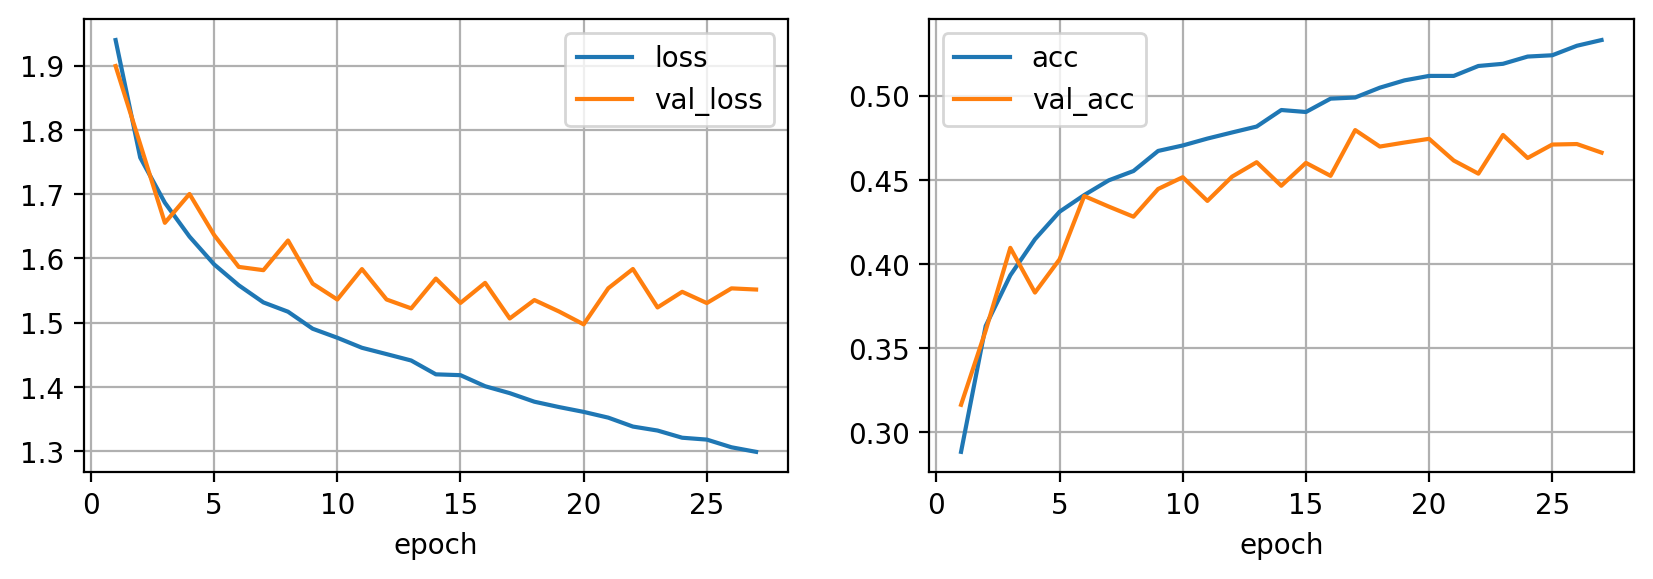

In [19]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como puedes observar la precisión de nuestro modelo ha aumentado considerablemente gracias al uso de más datos. De esta manera aprovechamos más capacidad del modelo.

## *Data Augmentation* 

Si bien conseguir más datos no siempre es factible, podemos llevar a cabo una simple idea: en vez de darle al modelo siempre nuestras imágenes en la misma manera, vamos a aplicar transformaciones de manera aleatoria de forma que, efectivamente, nuestro modelo no vea nunca la misma imagen dos veces consiguiendo así un dataset potencialmente infinito. Estas transformaciones deben alterar la imagen lo suficiente como para poder considerarla como una muestra diferente pero no tanto como para alterar su etiqueta. Algunos ejemplos de estas transformaciones incluyen: giros, recortes, alteraciones de color, brillo o tamaño, etc.

Existen muchas herramientas disponibles para aplicar transformaciones a imágenes (por ejemplo la misma librería de `torchvision` incluye algunas). Una elección popular es la librería [albumentations](https://github.com/albumentations-team/albumentations).

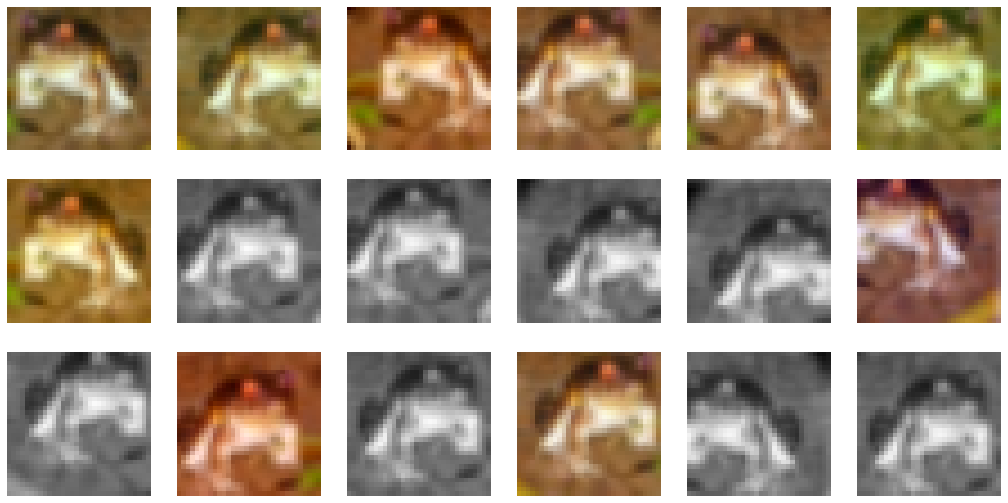

In [20]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(32, 32),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

idx = 0
r, c = 3, 6
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)
        img, label = trainset[idx]
        # apply transformation
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

En la figura anterior estás viendo un única muestra de nuestro dataset a la cual le hemos aplicado una serie de transformaciones que han alterado su apariencia sin modificar su etiqueta. Aplicando estas transformaciones aleatorias a cada muestra antes de dársela a la `red neuronal` obligará a nuestro a modelo a generalizar mucho más, reduciendo el *overfitting*. 

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().cuda().view(-1)
        label = torch.tensor(self.Y[ix]).long().cuda()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 10000)

In [24]:
model = build_model()
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.27420 en epoch 1
Mejor modelo guardado con acc 0.30850 en epoch 2
Mejor modelo guardado con acc 0.33240 en epoch 3
Mejor modelo guardado con acc 0.34840 en epoch 4
Mejor modelo guardado con acc 0.35350 en epoch 6
Mejor modelo guardado con acc 0.36170 en epoch 7
Epoch 10/100 loss 1.81497 acc 0.34327 val_loss 1.77981 val_acc 0.35820
Mejor modelo guardado con acc 0.36720 en epoch 11
Mejor modelo guardado con acc 0.37240 en epoch 13
Mejor modelo guardado con acc 0.38910 en epoch 15
Mejor modelo guardado con acc 0.39910 en epoch 18
Mejor modelo guardado con acc 0.39920 en epoch 19
Epoch 20/100 loss 1.76901 acc 0.35923 val_loss 1.69960 val_acc 0.39770
Mejor modelo guardado con acc 0.39940 en epoch 27
Epoch 30/100 loss 1.73868 acc 0.37407 val_loss 1.77354 val_acc 0.36940
Mejor modelo guardado con acc 0.42460 en epoch 32
Epoch 40/100 loss 1.71839 acc 0.38255 val_loss 1.65343 val_acc 0.40770
Epoch 50/100 loss 1.70084 acc 0.38693 val_loss 1.62469 val_acc 0.41300
E

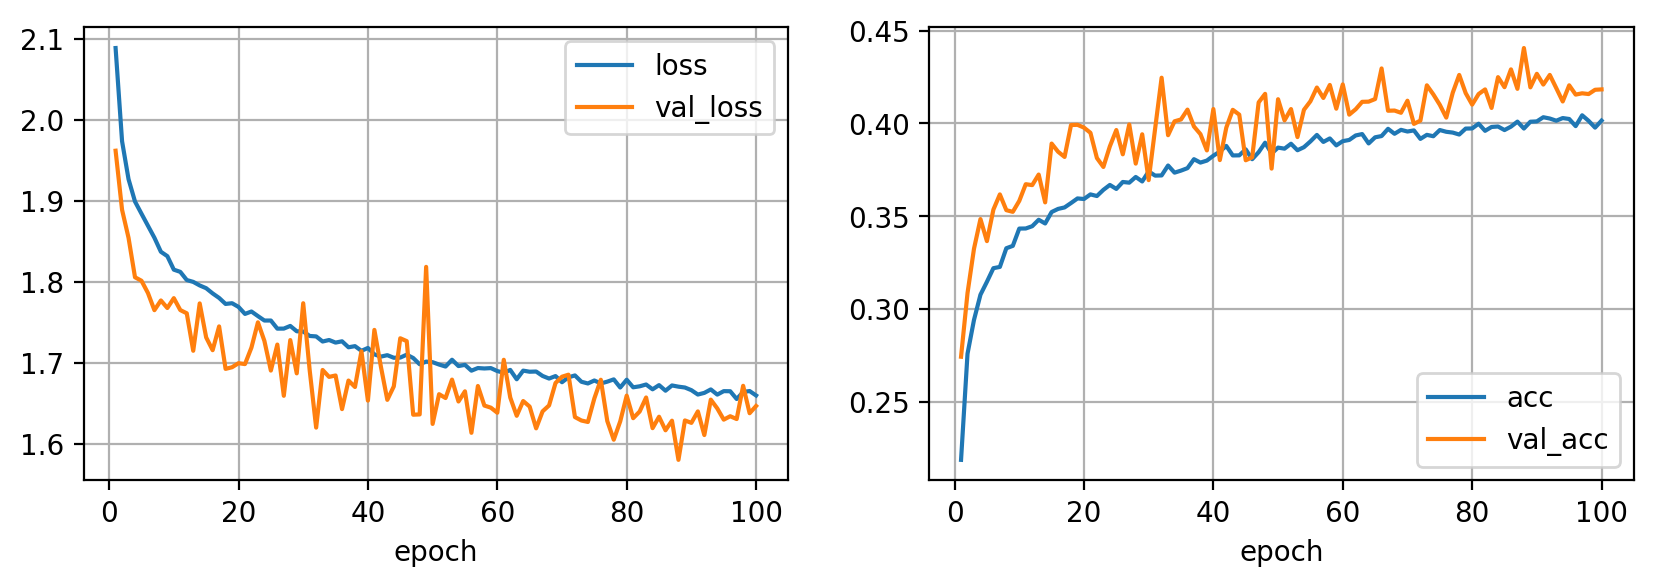

In [25]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

El uso de *data augmentation* requerirá de ciclos de entrenamiento más largos para poder aprovechar toda la capacidad que las transformaciones nos ofrecen. Una característica interesante de esta técnica es que podemos conseguir que las curvas de aprendizaje de validación estén por encima de las de entrenamiento, indicando que nuestro modelo realmente trabaja mejor en datos no vistos (lo cual no significa necesariamente que el modelo sea mejor, en este caso por ejemplo nuestras métricas no son tan buenas como en el caso anterior).

## Resumen

En este post hemos presentado varias técnicas para reducir el *overffiting* de nuestros modelos. Cuando estamos entrenando `redes neuronales` siempre es recomendable aplicar cualquier forma de regularización. De entre las técnicas presentadas en este post, el uso de *early stopping* y *data augmentation* (cuando trabajemos con imágenes) son de uso prácticamente obligado. La efectividad del resto de técnicas dependerá de tu caso, pero siempre es aconsejable probarlas para evaluar su potencial.